In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os
import glob

In [2]:
epochs = 100
lr = 1e-3
batch_size = 64
img_dims = (96, 96, 3)

data = []
gender_labels = []
age_labels = []

In [4]:
# Load image files from the dataset
image_files = [f for f in glob.glob(r'.\UTkFace' + "/**/*", recursive=True) if not os.path.isdir(f)]
random.shuffle(image_files)

# Converting images to arrays and labeling the categories
for img in image_files:
    image = cv2.imread(img)
    image = cv2.resize(image, (img_dims[0], img_dims[1]))
    image = img_to_array(image)
    data.append(image)

    label = img.split(os.path.sep)[-2]  # Assuming directory structure: ...\gender_age\woman_25\face_1162.jpg
    gender, age = label.split('_')

    # Encode gender
    if gender == "woman":
        gender_label = 1
    else:
        gender_label = 0
    
    # Encode age as a regression target or categorize into age groups
    age_label = int(age)  # Or categorize into age groups: [0-10], [11-20], etc.

    gender_labels.append(gender_label)
    age_labels.append(age_label)

In [ ]:
# pre-processing
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

In [ ]:
# split dataset for training and validation
trainX, testX, trainY, testY = train_test_split(data, labels, test_size=0.2, random_state=42)

trainY = to_categorical(trainY, num_classes=2)  # [[1, 0], [0, 1], [0, 1], ...]
testY = to_categorical(testY, num_classes=2)

In [ ]:
# augmenting dataset
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                         horizontal_flip=True, fill_mode="nearest")

In [ ]:
# define model
def build(width, height, depth, classes):
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1

    if K.image_data_format() == "channels_first":
        inputShape = (depth, height, width)
        chanDim = 1

    model.add(Conv2D(32, (3, 3), padding="same", input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(classes))
    model.add(Activation("sigmoid"))

    return model

In [ ]:
# build model
model = build(width=img_dims[0], height=img_dims[1], depth=img_dims[2], classes=2)

# compile the model
opt = Adam(learning_rate=lr)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# calculate the steps per epoch
steps_per_epoch = len(trainX) // batch_size

# train the model
H = model.fit(aug.flow(trainX, trainY, batch_size=batch_size),
              validation_data=(testX, testY),
              steps_per_epoch=steps_per_epoch,
              epochs=epochs, verbose=1)


C:\Users\okays\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


C:\Users\okays\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


28/28 ━━━━━━━━━━━━━━━━━━━━ 29s 824ms/step - accuracy: 0.6552 - loss: 0.9783 - val_accuracy: 0.6797 - val_loss: 0.6856
Epoch 2/100
 1/28 ━━━━━━━━━━━━━━━━━━━━ 20s 775ms/step - accuracy: 0.8281 - loss: 0.5405

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.1520.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.8281 - loss: 0.5405 - val_accuracy: 0.5303 - val_loss: 0.6945
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 23s 803ms/step - accuracy: 0.8092 - loss: 0.5057 - val_accuracy: 0.5152 - val_loss: 0.7667
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.8750 - loss: 0.2751 - val_accuracy: 0.5152 - val_loss: 0.7729
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 22s 735ms/step - accuracy: 0.8407 - loss: 0.4123 - val_accuracy: 0.5152 - val_loss: 0.8189
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.7969 - loss: 0.4993 - val_accuracy: 0.5152 - val_loss: 0.8297
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 738ms/step - accuracy: 0.8633 - loss: 0.3785 - val_accuracy: 0.5649 - val_loss: 0.6861
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.8281 - loss: 0.4479 - val_accuracy: 0.6169 - val_loss: 0.6578
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 22s 742ms/step - accuracy: 0.8760 - loss: 0.3136 - val_accuracy: 0.6277

In [ ]:
model.save('gender_detection.keras')

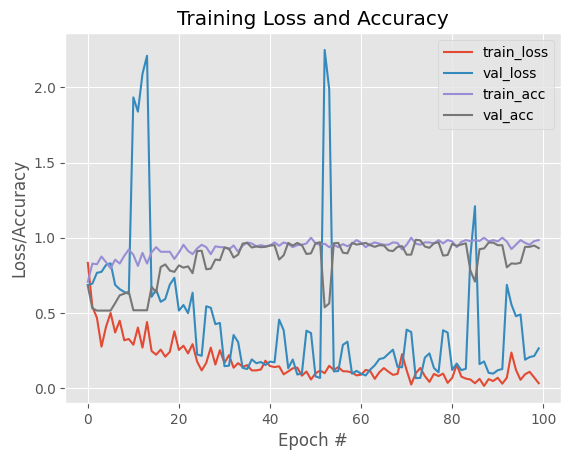

In [ ]:
# plot training/validation loss/accuracy
plt.style.use("ggplot")
plt.figure()
N = epochs
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")

# save plot to disk
plt.savefig('plot.png')
